# Environmental Sensor with Three Different Algorithms
## Anomarlly Detection, Regression and Classification 

### Import and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

### Data Loading and Exploration

In [2]:
df = pd.read_csv('feeds.csv')

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows: \n", df.head())
print("\nData types:\n", df.dtypes)
print("\nBasic stats:\n", df.describe())

Shape: (5189, 10)
Columns: ['created_at', 'entry_id', 'temperature', 'humidity', 'light_level', 'tilt_staus', 'latitude', 'longitude', 'elevation', 'status']

First 5 rows: 
                   created_at  entry_id  temperature  humidity light_level  \
0  2025-07-12T15:58:07+00:00         1           25        60    13.58297   
1  2025-07-12T15:58:27+00:00         2           25        60    15.35546   
2  2025-07-12T15:58:58+00:00         3           25        58    12.53559   
3  2025-07-12T15:59:18+00:00         4           25        58    15.51659   
4  2025-07-12T15:59:39+00:00         5           25        58        16.0   

   tilt_staus  latitude  longitude  elevation  status  
0    18.99901       NaN        NaN        NaN     NaN  
1    18.31388       NaN        NaN        NaN     NaN  
2    18.97459       NaN        NaN        NaN     NaN  
3    18.60685       NaN        NaN        NaN     NaN  
4    18.80369       NaN        NaN        NaN     NaN  

Data types:
 created_at  

### Data Cleaning
- #### Missing Values, Drop Columns with 100% Missing Values and Datarime Features

In [3]:
# Missing Values
missing_values = df.isnull().sum()
missing_percentage = (missing_values/len(df) * 100)
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage': missing_percentage})
print("Missing values:\n", missing_df)

# Drop Column with 100% Missing Values
columns_to_drop = missing_df[missing_df['Percentage']== 100].index.tolist()
df_cleaned = df.drop(columns=columns_to_drop)

print(f"\nDropped: {columns_to_drop}")
print(f"New Shape: {df_cleaned.shape}")

# Datetime Features
df_cleaned['created_at']= pd.to_datetime(df_cleaned['created_at'])
df_cleaned['year']= df_cleaned['created_at'].dt.year
df_cleaned['month']= df_cleaned['created_at'].dt.month
df_cleaned['day']= df_cleaned['created_at'].dt.day
df_cleaned['hour']= df_cleaned['created_at'].dt.hour
df_cleaned['minute']= df_cleaned['created_at'].dt.minute
df_cleaned['day_of_week']= df_cleaned['created_at'].dt.dayofweek
df_cleaned['day_of_year']= df_cleaned['created_at'].dt.dayofyear
print(f"\nDate range: {df_cleaned['created_at'].min()} to {df_cleaned['created_at'].max()}")
print("Temporal features added.")

Missing values:
              Missing Count  Percentage
created_at               0         0.0
entry_id                 0         0.0
temperature              0         0.0
humidity                 0         0.0
light_level              0         0.0
tilt_staus               0         0.0
latitude              5189       100.0
longitude             5189       100.0
elevation             5189       100.0
status                5189       100.0

Dropped: ['latitude', 'longitude', 'elevation', 'status']
New Shape: (5189, 6)

Date range: 2025-07-12 15:58:07+00:00 to 2025-09-15 12:12:24+00:00
Temporal features added.


- #### Clean light_level Column and Dublicates

In [4]:
non_numeric = df_cleaned[pd.to_numeric(df_cleaned['light_level'], errors='coerce').isna()]['light_level'].unique()
print(f"\nNon-numeric 'light_level': {non_numeric}")
df_cleaned['light_level'] = pd.to_numeric(df_cleaned['light_level'], errors='coerce')
nan_count = df_cleaned['light_level'].isna().sum()
if nan_count > 0:
    median_light = df_cleaned['light_level'].median()
    df_cleaned['light_level'].fillna(median_light, inplace=True)
    print(f"Filled {nan_count} NaNs in 'light_level' with median value: {median_light:.2f}")

# Duplicates
duplicate_count = df_cleaned.duplicated().sum()
if duplicate_count > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"\nDropped {duplicate_count} duplicate rows.")

# Save cleaned data
sensor_cols = ['temperature', 'humidity', 'light_level', 'tilt_status']
# df_cleaned.to_csv('feeds_cleaned.csv', index=False)


Non-numeric 'light_level': ['()']
Filled 331 NaNs in 'light_level' with median value: 24.64


## Isolation Forest Algorithm

In [14]:
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.size = 0
        self.is_external = False

    def fit(self, X, current_height=0):
        self.size = len(X)
        if current_height >= self.height_limit or len(X) <= 1:
            self.is_external = True
            return self
        if len(np.unique(X, axis=0)) == 1:
            self.is_external = True
            return self
        n_features = X.shape[1]
        self.split_feature = np.random.randint(0, n_features)
        feature_values = X[:, self.split_feature]
        min_val, max_val = feature_values.min(), feature_values.max()
        if min_val == max_val:
            self.is_external = True
            return self
        self.split_value = np.random.uniform(min_val, max_val)
        left_mask = feature_values < self.split_value
        right_mask = ~left_mask
        if left_mask.sum()> 0:
            self.left = IsolationTree(self.height_limit)
            self.left.fit(X[left_mask], current_height + 1)
        if right_mask.sum() > 0:
            self.right = IsolationTree(self.height_limit)
            self.right.fit(X[right_mask], current_height + 1)
        return self
    
    def path_length(self, x, current_height=0):
        if self.is_external:
            return current_height + self._c(self.size)
        if x[self.split_feature] < self.split_value:
            return self.left.path_length(x, current_height + 1) if self.left else current_height + 1
        else:
            return self.right.path_length(x, current_height + 1) if self.right else current_height + 1
        
    def _c(self, n):
        if n <= 1:
            return 0
        else:
            return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)
        
class IsolationForest:
    def __init__(self, n_trees=50, sample_size=256):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []
        self.height_limit = None

    def fit(self, X):
        n_samples = len(X)  # <-- fix typo here
        self.sample_size = min(self.sample_size, n_samples)
        self.height_limit = int(np.ceil(np.log2(self.sample_size)))
        print(f"Training IF: {self.n_trees} trees, sample size: {self.sample_size}, height limit: {self.height_limit}")
        for i in range(self.n_trees):
            sample_indices = np.random.choice(n_samples, self.sample_size, replace=False)
            tree = IsolationTree(self.height_limit)
            tree.fit(X[sample_indices])
            self.trees.append(tree)
            if (i+1) % 10 == 0:
                print(f"  Trees: {i+1}/{self.n_trees} trees")
        return self
    
    def anomaly_score(self, X):
        avg_path = np.mean([tree.path_length(X) for tree in self.trees])
        c = 2 * (np.log(self.sample_size - 1) + 0.5772156649) - (2 * (self.sample_size - 1) / self.sample_size)
        return 2 ** (-avg_path / c)
    
    def predict(self, X):
        return np.array([self.anomaly_score(x) for x in X])

## Train and Evaluate Isolation Forest

Training IF: 50 trees, sample size: 256, height limit: 8
  Trees: 10/50 trees
  Trees: 20/50 trees
  Trees: 30/50 trees
  Trees: 40/50 trees
  Trees: 50/50 trees
Anomalies: 198 (3.8%) | Threshold: 0.6

Score stats:
 count    5189.000000
mean        0.434432
std         0.073779
min         0.367748
25%         0.380753
50%         0.396521
75%         0.468047
max         0.685061
Name: anomaly_score, dtype: float64


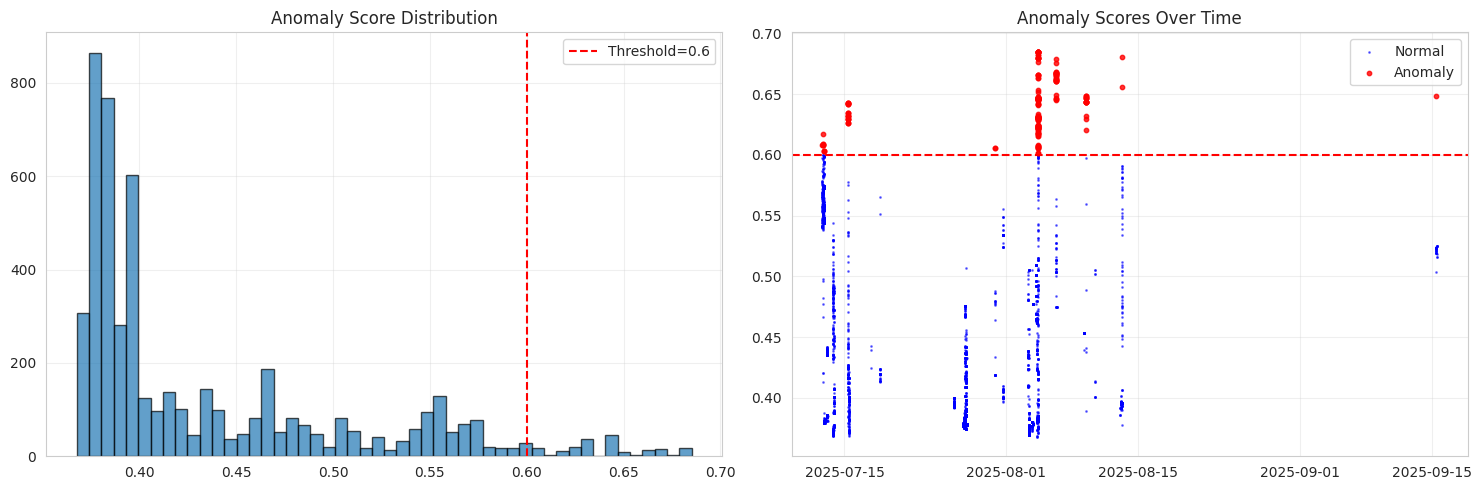


 Top 10 Anomalies:
                     created_at  temperature  humidity  light_level  \
4297 2025-08-04 09:12:17+00:00           40        14     14.74937   
4298 2025-08-04 09:12:42+00:00           40        14     15.45739   
4299 2025-08-04 09:13:06+00:00           40        14     14.77378   
4301 2025-08-04 09:13:54+00:00           40        14     12.84505   
4302 2025-08-04 09:14:18+00:00           40        14     12.40406   
4303 2025-08-04 09:14:42+00:00           40        14     12.33082   
4304 2025-08-04 09:15:06+00:00           40        14     12.64973   
4310 2025-08-04 09:17:31+00:00           40        14     14.33433   
4313 2025-08-04 09:18:44+00:00           40        14     13.82162   
4296 2025-08-04 09:11:53+00:00           40        14     17.45937   

      tilt_staus  anomaly_score  
4297         1.0       0.685061  
4298         1.0       0.685061  
4299         1.0       0.685061  
4301         1.0       0.685061  
4302         1.0       0.685061  
4303

In [16]:
from sklearn.preprocessing import StandardScaler
# Prepare data for Isolation Forest
sensor_features = ['temperature', 'humidity', 'light_level', 'tilt_staus']
X_anomaly = df_cleaned[sensor_features].values
scaler = StandardScaler()
X_anomaly_scaled = scaler.fit_transform(X_anomaly)

# Train and predict
iforest = IsolationForest()
iforest.fit(X_anomaly_scaled)
anomaly_scores = iforest.predict(X_anomaly_scaled)
df_cleaned['anomaly_score'] = anomaly_scores

# Results
threshold = 0.6
df_cleaned['is_anomaly'] = df_cleaned['anomaly_score'] > threshold
n_anomalies = df_cleaned['is_anomaly'].sum()
anomaly_percentage = (n_anomalies / len(df_cleaned)) * 100
print(f"Anomalies: {n_anomalies} ({anomaly_percentage:.1f}%) | Threshold: {threshold}")
print("\nScore stats:\n", df_cleaned['anomaly_score'].describe())

# Plots

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(anomaly_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
axes[0].set_title('Anomaly Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_cleaned[~df_cleaned['is_anomaly']]['created_at'],df_cleaned[~df_cleaned['is_anomaly']]['anomaly_score'], 
                c ='blue', s=1, label='Normal', alpha=0.5)
axes[1].scatter(df_cleaned[df_cleaned['is_anomaly']]['created_at'],df_cleaned[df_cleaned['is_anomaly']]['anomaly_score'],
                c='red', s=10, label='Anomaly', alpha=0.8)
axes[1].axhline(threshold, color='red', linestyle='--')
axes[1].set_title('Anomaly Scores Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Top 10 Anomalies:\n", df_cleaned.nlargest(10, 'anomaly_score')[['created_at'] + sensor_features + ['anomaly_score']])
